### Part 2: Poetry generation (for real)

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/24f_mipt/homeworks/lab03_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2024-12-15 19:46:02--  https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/24f_mipt/homeworks/lab03_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.1s    

2024-12-15 19:46:02 (1.07 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()
assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
assert not any([x in set(text) for x in string.ascii_uppercase]), "Uppercase letters are present"
print("OK!")

OK!


### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2020-05-10 19:02:32--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.1s    

2020-05-10 19:02:33 (2.25 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

Put all the characters, that you've seen in the text, into variable `tokens`.

In [8]:
out = text
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [9]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = {idx: token for idx, token in enumerate(tokens)}
print(len(tokens))
# dict <char>:<index>
# Your great code here

38


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
SEQ_LENGTH = 40
HIDDEN_SIZE = 128
EMBEDDING_DIM = 32
NUM_LAYERS = 1
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE =
MAX_LENGTH = 200

class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden_state):
        x = self.embedding(x)  # Embed input
        out, hidden_state = self.rnn(x, hidden_state)  # RNN forward
        out = self.fc(out)  # Fully connected layer
        return out, hidden_state

    def initial_state(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)


In [11]:
def create_sequences(data, seq_length):
    inputs = []
    targets = []
    for i in range(len(data) - seq_length):
        inputs.append(data[i : i + seq_length])
        targets.append(data[i + 1 : i + seq_length + 1])
    return np.array(inputs), np.array(targets)

encoded_text = [token_to_idx[char] for char in text]
inputs, targets = create_sequences(encoded_text, SEQ_LENGTH)

inputs = torch.tensor(inputs, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)
dataset = torch.utils.data.TensorDataset(inputs, targets)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [13]:
vocab_size = len(tokens)
model = CharRNN(vocab_size, EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    for batch_inputs, batch_targets in dataloader:
        hidden_state = hidden_state = model.initial_state(batch_inputs.size(0))
        batch_targets = batch_targets.view(-1)

        outputs, hidden_state = model(batch_inputs, hidden_state)
        outputs = outputs.view(-1, vocab_size)
        loss = criterion(outputs, batch_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {avg_loss:.4f}")


Epoch 1/20, Loss: 1.5632
Epoch 2/20, Loss: 1.3847
Epoch 3/20, Loss: 1.3546
Epoch 4/20, Loss: 1.3418
Epoch 5/20, Loss: 1.3361
Epoch 6/20, Loss: 1.3338
Epoch 7/20, Loss: 1.3335
Epoch 8/20, Loss: 1.3344
Epoch 9/20, Loss: 1.3366
Epoch 10/20, Loss: 1.3389
Epoch 11/20, Loss: 1.3444
Epoch 12/20, Loss: 1.3476
Epoch 13/20, Loss: 1.3499
Epoch 14/20, Loss: 1.3574
Epoch 15/20, Loss: 1.3573
Epoch 16/20, Loss: 1.3624
Epoch 17/20, Loss: 1.3723
Epoch 18/20, Loss: 1.3732
Epoch 19/20, Loss: 1.3782
Epoch 20/20, Loss: 1.3953


Plot the loss function (axis X: number of epochs, axis Y: loss function).

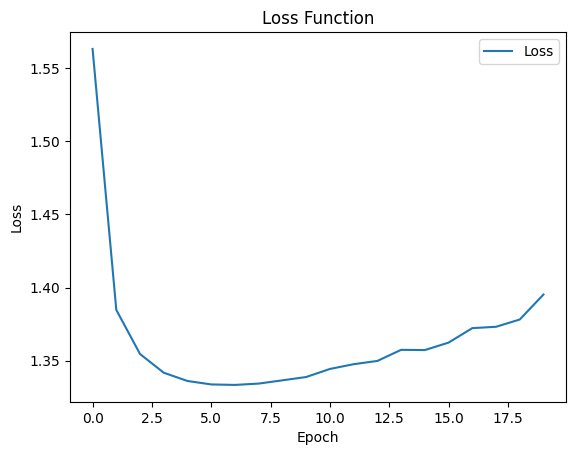

In [14]:
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Function")
plt.legend()
plt.show()


In [15]:
def generate_sample(char_rnn, seed_phrase=" hello", max_length=MAX_LENGTH, temperature=1.0):
    x_sequence = [token_to_idx[char] for char in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.long)
    hidden_state = char_rnn.initial_state(batch_size=1)

    for _ in range(max_length - len(seed_phrase)):
        out, hidden_state = char_rnn(x_sequence[:, -1:], hidden_state)
        probabilities = torch.softmax(out / temperature, dim=-1).data.numpy()[0, -1]
        next_idx = np.random.choice(len(tokens), p=probabilities)
        x_sequence = torch.cat([x_sequence, torch.tensor([[next_idx]], dtype=torch.long)], dim=1)

    return "".join([idx_to_token[idx] for idx in x_sequence[0].numpy()])


In [16]:

generated_text = generate_sample(model, seed_phrase="o Romeo", temperature=0.7)
print(f"Generated text:\n{generated_text}")


Generated text:
shall i compare thee thy fortan in long nor dead.

  lxv

  when i am be i hast shall he show,
  and child of heaven no moss,
  but a lived urge, the treasure!
    to readge to be make and to carignow


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

*Comment: if you wish, you can use small GPT as well (e.g. from https://github.com/karpathy/nanoGPT)*

Plot the loss function of the number of epochs. Does the final loss become better?

In [17]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden_state):
        x = self.embedding(x)  # Embed input
        out, hidden_state = self.lstm(x, hidden_state)  # LSTM forward
        out = self.fc(out)  # Fully connected layer
        return out, hidden_state

    def initial_state(self, batch_size):
        # Return initial hidden and cell states
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


In [18]:
# Initialize the model
model = CharLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    for batch_inputs, batch_targets in dataloader:
        batch_size = batch_inputs.size(0)
        hidden_state = model.initial_state(batch_size)
        batch_targets = batch_targets.view(-1)

        # Forward pass
        outputs, hidden_state = model(batch_inputs, hidden_state)
        outputs = outputs.view(-1, vocab_size)
        loss = criterion(outputs, batch_targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {avg_loss:.4f}")


Epoch 1/20, Loss: 1.4877
Epoch 2/20, Loss: 1.1688
Epoch 3/20, Loss: 1.0728
Epoch 4/20, Loss: 1.0254
Epoch 5/20, Loss: 0.9981
Epoch 6/20, Loss: 0.9798
Epoch 7/20, Loss: 0.9667
Epoch 8/20, Loss: 0.9562
Epoch 9/20, Loss: 0.9480
Epoch 10/20, Loss: 0.9409
Epoch 11/20, Loss: 0.9353
Epoch 12/20, Loss: 0.9308
Epoch 13/20, Loss: 0.9258
Epoch 14/20, Loss: 0.9225
Epoch 15/20, Loss: 0.9188
Epoch 16/20, Loss: 0.9155
Epoch 17/20, Loss: 0.9138
Epoch 18/20, Loss: 0.9112
Epoch 19/20, Loss: 0.9085
Epoch 20/20, Loss: 0.9059


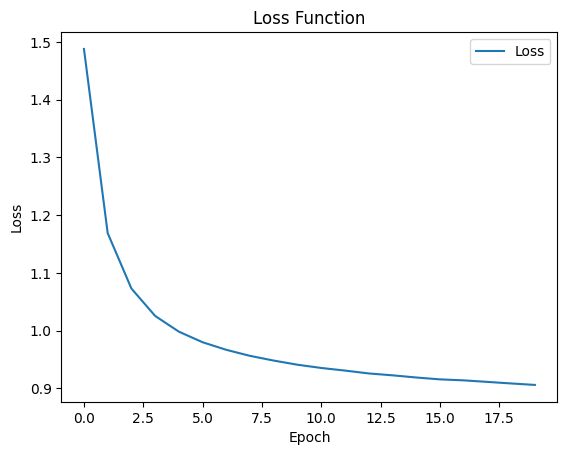

In [19]:
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Function")
plt.legend()
plt.show()


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [35]:
# Text generation with different temperature values here
def generate_sample_lstm(model, seed_phrase=" hello", max_length=MAX_LENGTH, temperature=1.0):
    x_sequence = [token_to_idx[char] for char in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.long)
    hidden_state = model.initial_state(batch_size=1)

    for _ in range(max_length - len(seed_phrase)):
        out, hidden_state = model(x_sequence[:, -1:], hidden_state)
        probabilities = torch.softmax(out / temperature, dim=-1).data.numpy()[0, -1]
        next_idx = np.random.choice(len(tokens), p=probabilities)
        x_sequence = torch.cat([x_sequence, torch.tensor([[next_idx]], dtype=torch.long)], dim=1)

    return "".join([idx_to_token[idx] for idx in x_sequence[0].numpy()])

# Generate text with different temperatures
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for temp in temperatures:
    print(f"\nTemperature: {temp}")
    print(generate_sample_lstm(model, seed_phrase="o romeo", temperature=temp))



Temperature: 0.1
shall i compare thee despite of hearts hath my love of thee, thy proud heart.

  liv

  if the world will be thy deep knows what with his brain is self-love thee shall be thy mind.
    o! least him th

Temperature: 0.2
shall i compare thee despite of him, i'll live in thee think the stars in my brand of praise,
  and so shall be the summer shall be thy deep know.
    but thence i soul thee have i seen
  than which p

Temperature: 0.5
shall i compare theeases are me with thy sad.

  xxii

  my love's wish is so ill,
  that day with their pride as thy grace is best.
  if thy love and all things raist precious part,
  whilst mine own

Temperature: 1.0
shall i compare theed mind
  with milling bears a limble love is blind shopend,
  and by, for thine eyes wert which thou a better is tend
  same knows made, to leave for my brass aht,
  and for conspi

Temperature: 2.0
shall i compare theed-widl dead wisulbs dose,
  gid well-was you'n woummnanued;
  and what ityl' to longer

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [38]:
torch.save(model.state_dict(), "char_lstm_model.pth")
print("Model saved to char_lstm_model.pth")
loaded_model = CharLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS)
loaded_model.load_state_dict(torch.load("char_lstm_model.pth", weights_only=True))
loaded_model.eval()
print("Model loaded from char_lstm_model.pth")
print(generate_sample_lstm(loaded_model, seed_phrase="o romeo", temperature=0.8))


Model saved to char_lstm_model.pth
Model loaded from char_lstm_model.pth
o romeomethinks well steel'd.
    past lacking wretch to the beauty hand defart
  the disard to your most abody tearies,
  or shall i shall still should cannot by a thrack'd thee have i call,
    sing


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)
4. nanoGPT by Andrej Karpathy: https://github.com/karpathy/nanoGPT